In [0]:
from IPython.display import Image, display_png, display_jpeg



```
# これはコードとして書式設定されます

```
# これはコードとして書式設定されます
```


```

## 【問題1】機械翻訳の実行とコードリーディング

In [0]:
!wget http://www.manythings.org/anki/fra-eng.zip
!unzip fra-eng.zip -d fra-eng

- コードリーディングをし、コメントを挿入していく(日本語)
### 使い方がわからなかった一覧
- python組み込み関数  
[set()](https://docs.python.org/ja/3/library/stdtypes.html#set-types-set-frozenset)  
[open()](https://docs.python.org/ja/3/library/functions.html#open)  
- kerasAPI  
[Model()](https://keras.io/ja/models/model/)  
[Input()](https://keras.io/ja/layers/core/#input)

In [17]:
'''
#Sequence to sequence example in Keras (character-level).
This script demonstrates how to implement a basic character-level
sequence-to-sequence model. We apply it to translating
short English sentences into short French sentences,
character-by-character. Note that it is fairly unusual to
do character-level machine translation, as word-level
models are more common in this domain.
**Summary of the algorithm**
- We start with input sequences from a domain (e.g. English sentences)
    and corresponding target sequences from another domain
    (e.g. French sentences).
- An encoder LSTM turns input sequences to 2 state vectors
    (we keep the last LSTM state and discard the outputs).
- A decoder LSTM is trained to turn the target sequences into
    the same sequence but offset by one timestep in the future,
    a training process called "teacher forcing" in this context.
    It uses as initial state the state vectors from the encoder.
    Effectively, the decoder learns to generate `targets[t+1...]`
    given `targets[...t]`, conditioned on the input sequence.
- In inference mode, when we want to decode unknown input sequences, we:
    - Encode the input sequence into state vectors
    - Start with a target sequence of size 1
        (just the start-of-sequence character)
    - Feed the state vectors and 1-char target sequence
        to the decoder to produce predictions for the next character
    - Sample the next character using these predictions
        (we simply use argmax).
    - Append the sampled character to the target sequence
    - Repeat until we generate the end-of-sequence character or we
        hit the character limit.
**Data download**
[English to French sentence pairs.
](http://www.manythings.org/anki/fra-eng.zip)
[Lots of neat sentence pairs datasets.
](http://www.manythings.org/anki/)
**References**
- [Sequence to Sequence Learning with Neural Networks
   ](https://arxiv.org/abs/1409.3215)
- [Learning Phrase Representations using
    RNN Encoder-Decoder for Statistical Machine Translation
    ](https://arxiv.org/abs/1406.1078)
'''

from __future__ import print_function

from keras.models import Model
from keras.layers import Input, LSTM, Dense
import numpy as np

# ハイパーパラメータの設定
batch_size = 64  # Batch size for training.
epochs = 30  # Number of epochs to train for.(changed 100 to 30)
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.
# Path to the data txt file on disk.
data_path = 'fra-eng/fra.txt'

# Vectorize the data.

# 格納用初期化
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()

# txtを読み込み行ごとsplit
with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')

# num_samples or txtの行数 - 1 のうち少ない回数分 下記処理を繰り返す
for line in lines[: min(num_samples, len(lines) - 1)]:
    # タブ区切りでinputとtargetにセパレート
    input_text, target_text = line.split('\t')
    
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    
    # 文字単位で区切って格納
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

# list化してソート
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
# 単語の最大長を取得
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

# 各charの辞書を作成する
input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

# 各種データ格納用配列を初期化
encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

# input・targetをそれぞれchar単位でループ
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        # input_token_indexを元に出現したindexの値を1にする
        # 例) 2番目のtextの5番目のcharが「a」だった
        # かつinput_token_index{0: a, ...}の場合
        # → encoder_input_data[1, 4, 0] = 1.
        encoder_input_data[i, t, input_token_index[char]] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # 最初のcharは含めない
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.

# モデルを定義
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
# shape・dtypeが定義されたtensorを取得
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)

# shape・dtypeが定義されたtensorを取得
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# 取得したtensorを元にinput・outputのshapeを定義
# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)
# Save model
model.save('s2s.h5')

# Next: inference mode (sampling).
# Here's the drill:
# 1) encode input and retrieve initial decoder state
# 2) run one step of decoder with this initial state
# and a "start of sequence" token as target.
# Output will be the next target token
# 3) Repeat with the current target token and current states

# 予測用のモデルを定義
# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())


# 作成した予測用モデルを元に、英→仏のデコードを行う(関数としてはほんとはモデルを渡す形にした方が良さそう)
def decode_sequence(input_seq):
    # input_seqを予測
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # decode後のseq配列を初期化
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # charがmax lengthになるまでループ
    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        # デコード後の予測
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # 予測を元に一番確率の高いcharを取得し、文字を連結
        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # 出現した単語を1に更新
        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # inputのshapeを更新
        # Update states
        states_value = [h, c]

    return decoded_sentence

Number of samples: 10000
Number of unique input tokens: 70
Number of unique output tokens: 93
Max sequence length for inputs: 16
Max sequence length for outputs: 59
Train on 8000 samples, validate on 2000 samples
Epoch 1/30
8000/8000 [==============================] - 63s 8ms/step - loss: 0.9208 - val_loss: 0.9592
Epoch 2/30
8000/8000 [==============================] - 60s 7ms/step - loss: 0.7397 - val_loss: 0.7743
Epoch 3/30
8000/8000 [==============================] - 59s 7ms/step - loss: 0.6222 - val_loss: 0.6835
Epoch 4/30
8000/8000 [==============================] - 59s 7ms/step - loss: 0.5644 - val_loss: 0.6395
Epoch 5/30
8000/8000 [==============================] - 61s 8ms/step - loss: 0.5240 - val_loss: 0.5928
Epoch 6/30
8000/8000 [==============================] - 64s 8ms/step - loss: 0.4910 - val_loss: 0.5712
Epoch 7/30
8000/8000 [==============================] - 65s 8ms/step - loss: 0.4653 - val_loss: 0.5439
Epoch 8/30
8000/8000 [==============================] - 65s 8ms/st

/usr/local/lib/python3.6/dist-packages/keras/engine/network.py:877: UserWarning: Layer lstm_6 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_5/while/Exit_2:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'lstm_5/while/Exit_3:0' shape=(?, 256) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


In [18]:
for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

-
Input sentence: Go.
Decoded sentence: Pars !

-
Input sentence: Hi.
Decoded sentence: Attrape tom eux le semoide.

-
Input sentence: Hi.
Decoded sentence: Attrape tom eux le semoide.

-
Input sentence: Run!
Decoded sentence: Prends-toi !

-
Input sentence: Run!
Decoded sentence: Prends-toi !

-
Input sentence: Who?
Decoded sentence: Qui a fait ça ?

-
Input sentence: Wow!
Decoded sentence: Regardez le remment.

-
Input sentence: Fire!
Decoded sentence: Apporte à manger !

-
Input sentence: Help!
Decoded sentence: Va au chie cour !

-
Input sentence: Jump.
Decoded sentence: Bonne je ne suis peur !

-
Input sentence: Stop!
Decoded sentence: Arrête de mentir.

-
Input sentence: Stop!
Decoded sentence: Arrête de mentir.

-
Input sentence: Stop!
Decoded sentence: Arrête de mentir.

-
Input sentence: Wait!
Decoded sentence: Attends !

-
Input sentence: Wait!
Decoded sentence: Attends !

-
Input sentence: Go on.
Decoded sentence: Va au !

-
Input sentence: Go on.
Decoded sentence: Va au !



変換はできてないものの単語は形成できている。  
もう少し学習させれば精度は上がりそう
## 【問題2】イメージキャプショニングの学習済みモデルの実行

In [0]:
# Clone the repositories
!git clone https://github.com/pdollar/coco.git
%cd coco/PythonAPI/
!make
!python setup.py build
!python setup.py install
%cd ../../
!git clone https://github.com/yunjey/pytorch-tutorial.git

In [0]:
# DL pretrained model and vocab file
!wget https://www.dropbox.com/s/ne0ixz5d58ccbbz/pretrained_model.zip
!wget https://www.dropbox.com/s/26adb7y9m98uisa/vocap.zip
!unzip \*.zip

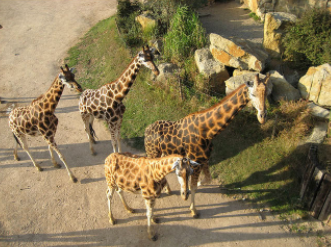

In [7]:
img_file = 'pytorch-tutorial/tutorials/03-advanced/image_captioning/png/example.png'
display_png(Image(img_file))

In [8]:
# Test the model
!python pytorch-tutorial/tutorials/03-advanced/image_captioning/sample.py \
--image='pytorch-tutorial/tutorials/03-advanced/image_captioning/png/example.png' \
--encoder_path 'encoder-5-3000.pkl' \
--decoder_path 'decoder-5-3000.pkl' \
--vocab_path 'vocab.pkl'

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/checkpoints/resnet152-b121ed2d.pth
100% 241530880/241530880 [00:08<00:00, 27846446.22it/s]
<start> a group of giraffes standing next to each other . <end>


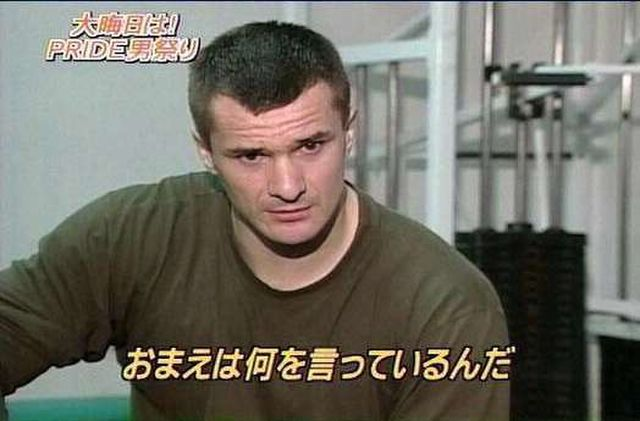

In [14]:
img_file = 'mirko.jpeg'
display_jpeg(Image(img_file))

In [13]:
# Test the model
!python pytorch-tutorial/tutorials/03-advanced/image_captioning/sample.py \
--image='mirko.jpeg' \
--encoder_path 'encoder-5-3000.pkl' \
--decoder_path 'decoder-5-3000.pkl' \
--vocab_path 'vocab.pkl'

<start> a man is holding a remote in his hand . <end>


えっ  
## 【問題3】Kerasで動かしたい場合はどうするかを調査
- コードはモデルをbuildしている箇所でkerasのレイヤーに書き換える必要がありそう  
https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/03-advanced/image_captioning/sample.py#L36-L40
- 異なるフレームワーク間で同じモデル(pkl)のロードはできなさそう  
→ モデルコンバーター的なライブラリがあるのでそれでconv pytorch to kerasする必要がありそう
https://forums.fast.ai/t/converting-a-pytorch-model-to-tensorflow-or-keras-for-production/14016/4  
https://github.com/Microsoft/MMdnn